In [1]:
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harsha/anaconda3/envs/finance/lib/pyt

### Dataset

### Model

In [2]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'random'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'random'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

#### Select small or large model config

In [3]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'large' # or 'large'

In [4]:
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_los

In [5]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "4+"}
    train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

In [6]:
# Select checkpoint
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

### Evaluation

In [7]:
# Load and evaluate model
# Create model object in inference mode.
config.NUM_TARGETS = 1
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

# Evaluate on the validation set
print('starting evaluation ...')


W1206 20:35:20.374987 140584039393088 deprecation_wrapper.py:119] From /home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1206 20:35:20.742636 140584039393088 deprecation_wrapper.py:119] From /home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1206 20:35:20.768942 140584039393088 deprecation_wrapper.py:119] From /home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1206 20:35:20.872476 140584039393088 deprecation_wrapper.py:119] From /home/harsha/anaconda3/envs/finance/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is depre

loading checkpoints/large_siamese_mrcnn_coco_full_0320.h5 ...
starting from epoch 320
starting evaluation ...


### Visualization

Processing 1 images
image                    shape: (670, 1185, 3)        min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 192, 192, 3)   min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 1, 192, 192, 3)   min:    8.00000  max:  255.00000  uint8
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


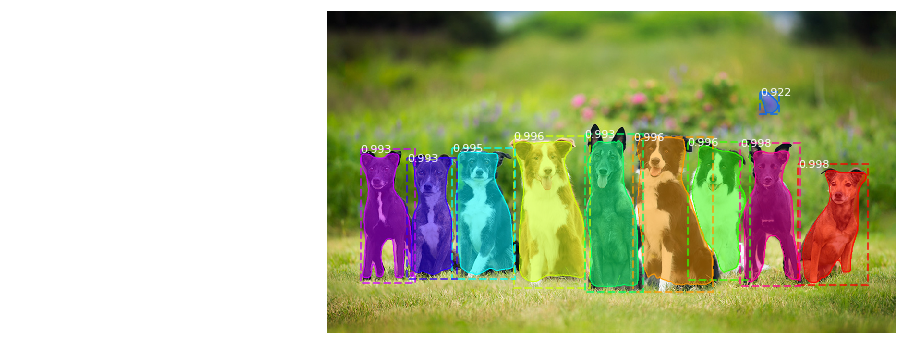

In [8]:
# Select category
from PIL import Image
image = np.array(Image.open("dogs.jpg"))
# for small : [1, 96, 96, 3], large : [1, 192, 192, 3]
target = np.array(Image.open("dog.jpg").resize((192, 192), Image.BICUBIC))


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])